In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from sqlalchemy import create_engine
import requests
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
RANDOM_STATE = 42
ORIG_DATA_PATH = Path('../orig_data')
DATA_PATH = Path('../data')

In [4]:
plt.rcParams['figure.figsize'] = (8, 6)

# Data Understanding

## Collect initial data

### Original data

In [5]:
if not ORIG_DATA_PATH.exists():
    ORIG_DATA_PATH.mkdir(exist_ok=True)

In [6]:
urls = ['https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_training.csv',
        'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_test.csv',
        'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_validation.csv']

file_paths = [ORIG_DATA_PATH/'train_df.csv', 
              ORIG_DATA_PATH/'test_df.csv',
              ORIG_DATA_PATH/'valid_df.csv']

def download_file(url, file_path):
    if not file_path.exists():
        r = requests.get(url)

        with open(file_path, 'w') as f:
            f.write(r.text[3:])
        
for url, file_path in tqdm(zip(urls, file_paths)):
    download_file(url, file_path)

3it [00:00, 6439.57it/s]


In [7]:
dfs = []

for file_path in tqdm(file_paths):
    dfs.append(pd.read_csv(file_path, low_memory=False))
    
full_df = pd.concat(dfs, axis=0)
full_df = full_df.drop('PII', axis=1)
print(full_df.shape)
full_df.head()

100%|██████████| 3/3 [00:00<00:00, 21.27it/s]


(26248, 41)


,id,split,message,original,genre,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


### Project data

In [8]:
messages_df = pd.read_csv(DATA_PATH/'disaster_messages.csv')
messages_df.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [9]:
categories_df = pd.read_csv(DATA_PATH/'disaster_categories.csv')
categories_df.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


## Describe data

### Original data

In [10]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26248 entries, 0 to 2572
Data columns (total 41 columns):
id                        26248 non-null int64
split                     26248 non-null object
message                   26248 non-null object
original                  10184 non-null object
genre                     26248 non-null object
related                   26248 non-null int64
request                   26248 non-null int64
offer                     26248 non-null int64
aid_related               26248 non-null int64
medical_help              26248 non-null int64
medical_products          26248 non-null int64
search_and_rescue         26248 non-null int64
security                  26248 non-null int64
military                  26248 non-null int64
child_alone               26248 non-null int64
water                     26248 non-null int64
food                      26248 non-null int64
shelter                   26248 non-null int64
clothing                  26248 non-null i

In [11]:
full_df.loc[:, 'related':].apply(pd.value_counts).T

,0,1,2
related,6125.0,19930.0,193.0
request,21768.0,4480.0,NaN
offer,26129.0,119.0,NaN
aid_related,15370.0,10878.0,NaN
medical_help,24161.0,2087.0,NaN
medical_products,24934.0,1314.0,NaN
search_and_rescue,25524.0,724.0,NaN
security,25777.0,471.0,NaN
military,25388.0,860.0,NaN
child_alone,26248.0,NaN,NaN


In [12]:
full_df.duplicated(keep=False).sum()

63

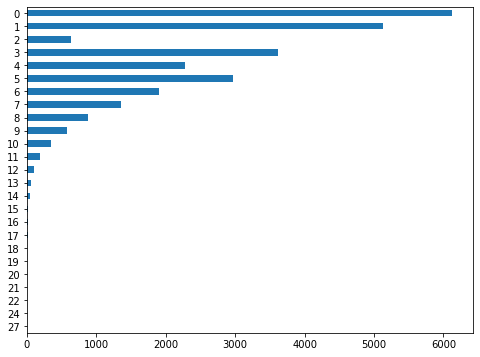

In [13]:
full_df.loc[:, 'related':].sum(axis=1).value_counts().sort_index(ascending=False).plot.barh()

### Project data

**Messages**

In [14]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 4 columns):
id          26248 non-null int64
message     26248 non-null object
original    10184 non-null object
genre       26248 non-null object
dtypes: int64(1), object(3)
memory usage: 820.4+ KB


In [15]:
messages_df.describe(include='all')

,id,message,original,genre
count,26248.000000,26248,10184,26248
unique,NaN,26177,9630,3
top,NaN,#NAME?,Nap fe ou konnen ke apati de jodi a sevis SMS ...,news
freq,NaN,4,20,13068
mean,15224.078368,NaN,NaN,NaN
std,8826.069156,NaN,NaN,NaN
min,2.000000,NaN,NaN,NaN
25%,7445.750000,NaN,NaN,NaN
50%,15660.500000,NaN,NaN,NaN
75%,22923.250000,NaN,NaN,NaN


In [16]:
messages_df.duplicated(keep=False).sum()

135

**Categories**

In [17]:
categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 2 columns):
id            26248 non-null int64
categories    26248 non-null object
dtypes: int64(1), object(1)
memory usage: 410.2+ KB


In [18]:
categories_df.duplicated(keep=False).sum()

63

In [19]:
categories_df.describe(include='all')

,id,categories
count,26248.000000,26248
unique,NaN,4003
top,NaN,related-0;request-0;offer-0;aid_related-0;medi...
freq,NaN,6125
mean,15224.078368,NaN
std,8826.069156,NaN
min,2.000000,NaN
25%,7445.750000,NaN
50%,15660.500000,NaN
75%,22923.250000,NaN


## Explore data

### Messages

**id**

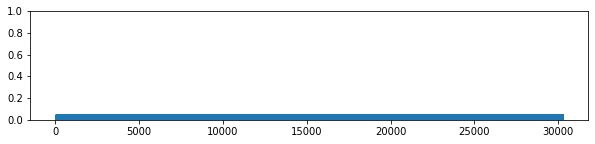

In [20]:
plt.figure(figsize=(10, 2))
sns.rugplot(messages_df['id'])

**message**

In [21]:
messages_df['message'].value_counts(dropna=False).head()

#NAME?                                                                                                                                                                                  4
Shelter materials (thick polyesters) are being distributed to 18,000 households.                                                                                                        3
In a field in Jallouzai, just inside Pakistan, 80,000 Afghans are jammed in without proper shelter, sanitation or water.                                                                2
Starting in October 1999, severe food insecurity began to be reported in Gode zone, Somali Region, as a result of delayed and erratic Deyr rains (expected from September-December).    2
I'd like to know an email to find a job                                                                                                                                                 2
Name: message, dtype: int64

In [22]:
messages_df['message'].str.len().describe()

count    26248.000000
mean       144.754267
std        207.170242
min          4.000000
25%         75.000000
50%        124.000000
75%        179.000000
max      10818.000000
Name: message, dtype: float64

In [23]:
messages_df[messages_df['message'].str.len() < 30]

,id,message,original,genre
351,425,"Need food, water and medicine","Nous avons besoin des tentes, de la nourriture...",direct
1473,1721,sports information. football.,informations sportives. football,direct
1571,1827,I'm a chauffeur. I need work.,Mwen se yon chof mwen bezwen travay,direct
2528,2913,"I miss you terribly, my dear.",Tu me manques normement chouchou!,direct
2954,3406,I would like to get info. ..,Je voudrais avoir des infos. ..,direct
3787,4340,"I live in Belaire, I need ..",mwen rete belaire mwen bezwen. .. ..,direct
6797,7700,paklascencion##s,Paklascencion##s,direct
7141,8057,9GeQYeYGQEQtm,9GeQYeYGQEQtmi,direct
7266,8192,0H 8@@ @2x @e8x3 xr,0Hlt 8@@ @2x @e8x3 xr a,direct
7559,8497,//// // @:@,//// // @lt : gt@,direct


**original**

In [24]:
messages_df['original'].str.len().describe()

count    10184.000000
mean        85.360369
std         45.029406
min          1.000000
25%         49.000000
50%         70.000000
75%        119.000000
max        327.000000
Name: original, dtype: float64

In [25]:
messages_df['original'].value_counts(dropna=False).head()

NaN                                                                                                                                                          16064
Nap fe ou konnen ke apati de jodi a sevis SMS 4636 pou enfomasyon ijan                                                                                          20
Un front froid se retrouve sur Cuba ce matin. Il pourrait traverser Haiti demain. Des averses de pluie isolee sont encore prevues sur notre region ce soi       19
4636 : Nasyonzini di ou men m retire kounye a tout fatra ak gravwa nan#                                                                                          7
Enfomasyon sou tranbleman ta a                                                                                                                                   6
Name: original, dtype: int64

**genre**

In [26]:
messages_df['genre'].value_counts(dropna=False)

news      13068
direct    10782
social     2398
Name: genre, dtype: int64

In [27]:
messages_df.groupby([messages_df['original'].isnull(), 'genre'])['id'].count()

original  genre 
False     direct    10184
True      direct      598
          news      13068
          social     2398
Name: id, dtype: int64

### Categories

**id**

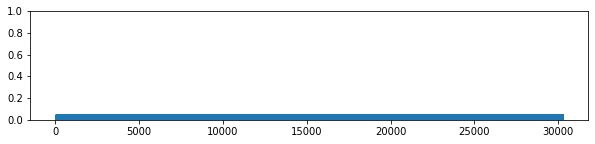

In [28]:
plt.figure(figsize=(10, 2))
sns.rugplot(categories_df['id'])

**categories**

In [29]:
categories_df['categories'].value_counts(dropna=False).head()

related-0;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0    6125
related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0    5123
related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescu

# Data Preparation

## Select data

### Messages

In [30]:
clean_messages_df = messages_df.drop_duplicates()
clean_messages_df = clean_messages_df[['id', 'message']]
clean_messages_df

,id,message
0,2,Weather update - a cold front from Cuba that c...
1,7,Is the Hurricane over or is it not over
2,8,Looking for someone but no name
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...
4,12,"says: west side of Haiti, rest of the country ..."
...,...,...
26243,30261,The training demonstrated how to enhance micro...
26244,30262,A suitable candidate has been selected and OCH...
26245,30263,"Proshika, operating in Cox's Bazar municipalit..."
26246,30264,"Some 2,000 women protesting against the conduc..."


### Categories

In [31]:
clean_categories_df = categories_df.drop_duplicates()
clean_categories_df = clean_categories_df[['id', 'categories']]
clean_categories_df.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


## Clean data

### Messages

### Categories

In [32]:
parsed_categories = clean_categories_df['categories'].str.split(';|-')
parsed_categories_df = parsed_categories.str[1::2].apply(pd.Series)
parsed_categories_df = parsed_categories_df.astype('int8')
parsed_categories_df.columns = parsed_categories.str[0::2].iloc[0]
parsed_categories_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26216 entries, 0 to 26247
Data columns (total 36 columns):
related                   26216 non-null int8
request                   26216 non-null int8
offer                     26216 non-null int8
aid_related               26216 non-null int8
medical_help              26216 non-null int8
medical_products          26216 non-null int8
search_and_rescue         26216 non-null int8
security                  26216 non-null int8
military                  26216 non-null int8
child_alone               26216 non-null int8
water                     26216 non-null int8
food                      26216 non-null int8
shelter                   26216 non-null int8
clothing                  26216 non-null int8
money                     26216 non-null int8
missing_people            26216 non-null int8
refugees                  26216 non-null int8
death                     26216 non-null int8
other_aid                 26216 non-null int8
infrastructure_re

In [33]:
clean_categories_df = clean_categories_df.drop('categories', axis=1)
clean_categories_df = pd.concat([clean_categories_df, parsed_categories_df], axis=1)
clean_categories_df.loc[:, 'related':].apply(pd.value_counts).T

,0,1,2
related,6122.0,19906.0,188.0
request,21742.0,4474.0,NaN
offer,26098.0,118.0,NaN
aid_related,15356.0,10860.0,NaN
medical_help,24132.0,2084.0,NaN
medical_products,24903.0,1313.0,NaN
search_and_rescue,25492.0,724.0,NaN
security,25745.0,471.0,NaN
military,25356.0,860.0,NaN
child_alone,26216.0,NaN,NaN


In [34]:
related_map = {0: 0, 1: 1, 2: 0}

clean_categories_df = clean_categories_df.drop('child_alone', axis=1)
clean_categories_df['related'] = clean_categories_df['related'].map(related_map).astype('int8')
clean_categories_df.loc[:, 'related':].apply(pd.value_counts).T

,0,1
related,6310,19906
request,21742,4474
offer,26098,118
aid_related,15356,10860
medical_help,24132,2084
medical_products,24903,1313
search_and_rescue,25492,724
security,25745,471
military,25356,860
water,24544,1672


## Integrate data

In [35]:
clean_df = clean_messages_df.merge(clean_categories_df, how='inner', on='id')
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26216 entries, 0 to 26215
Data columns (total 37 columns):
id                        26216 non-null int64
message                   26216 non-null object
related                   26216 non-null int8
request                   26216 non-null int8
offer                     26216 non-null int8
aid_related               26216 non-null int8
medical_help              26216 non-null int8
medical_products          26216 non-null int8
search_and_rescue         26216 non-null int8
security                  26216 non-null int8
military                  26216 non-null int8
water                     26216 non-null int8
food                      26216 non-null int8
shelter                   26216 non-null int8
clothing                  26216 non-null int8
money                     26216 non-null int8
missing_people            26216 non-null int8
refugees                  26216 non-null int8
death                     26216 non-null int8
other_aid     

# Data Understanding

## Explore data

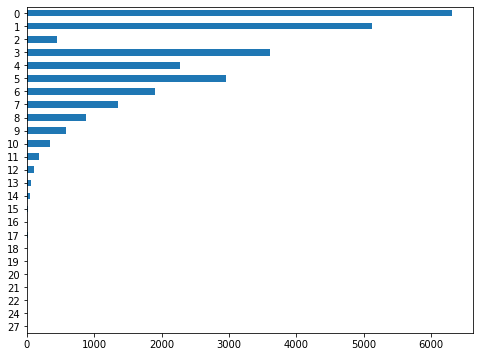

In [36]:
clean_df.loc[:, 'related':].sum(axis=1).value_counts().sort_index(ascending=False).plot.barh()

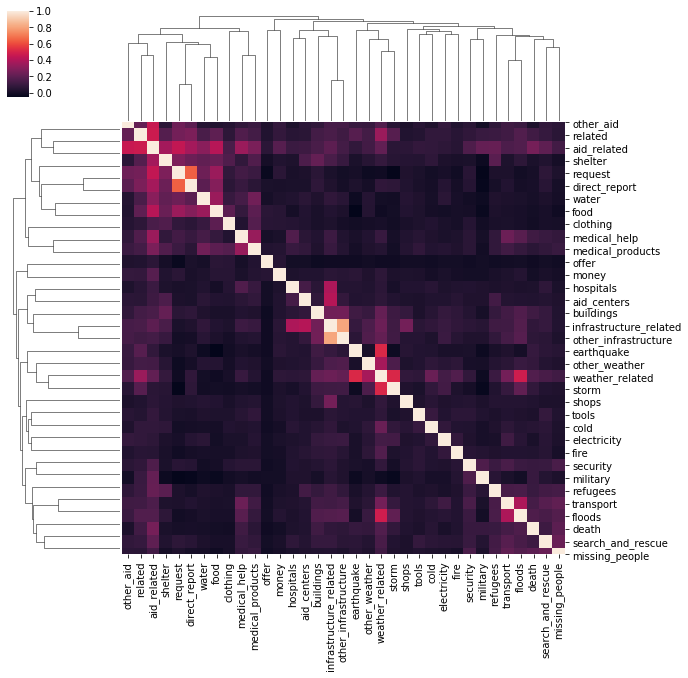

In [37]:
sns.clustermap(clean_df.loc[:, 'related':].corr())

In [38]:
clean_df.groupby('related').apply(lambda x: x.loc[:, 'request':].sum()).sum(axis=1)

related
0        0
1    63041
dtype: int64

In [39]:
clean_df.groupby(['other_aid', 'related', 'aid_related'])['id'].count()

other_aid  related  aid_related
0          0        0              6310
           1        0              9046
                    1              7414
1          1        1              3446
Name: id, dtype: int64

In [40]:
clean_df.groupby(['request', 'direct_report'])['id'].count()

request  direct_report
0        0                20058
         1                 1684
1        0                 1083
         1                 3391
Name: id, dtype: int64

In [41]:
clean_df.groupby(['medical_help', 'medical_products', 'aid_related'])['id'].count()

medical_help  medical_products  aid_related
0             0                 0              15356
                                1               8095
              1                 1                681
1             0                 1               1452
              1                 1                632
Name: id, dtype: int64

In [42]:
clean_df.groupby(['hospitals', 'aid_centers', 'infrastructure_related'])['id'].count()

hospitals  aid_centers  infrastructure_related
0          0            0                         24511
                        1                          1156
           1            1                           266
1          0            1                           240
           1            1                            43
Name: id, dtype: int64

In [43]:
clean_df.groupby(['infrastructure_related', 'other_infrastructure'])['id'].count()

infrastructure_related  other_infrastructure
0                       0                       24511
1                       0                         554
                        1                        1151
Name: id, dtype: int64

In [44]:
clean_df.groupby(['other_weather', 'weather_related'])['id'].count()

other_weather  weather_related
0              0                  18919
               1                   5921
1              1                   1376
Name: id, dtype: int64

In [45]:
clean_df.groupby(['transport', 'floods'])['id'].count()

transport  floods
0          0         23557
           1          1458
1          0           504
           1           697
Name: id, dtype: int64

Rules:
- child_alone = 0
- related = 0 => all another classes == 0
- other_aid = 1 => related = 1, aid_related = 1
- medical_products = 1 => aid_related = 1
- aid_centers = 1 => infrastructure_related = 1
- infrastructure_related = 0 => other_infrastructure = 0
- other_weather = 1 => weather_related = 1

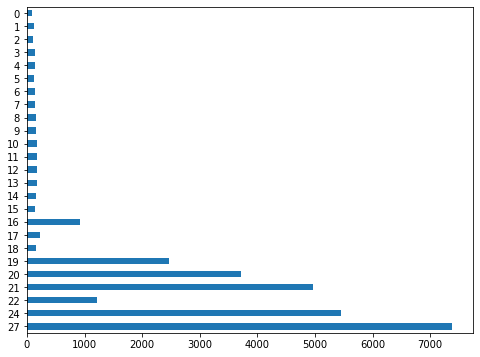

In [46]:
clean_df.groupby(clean_df.loc[:, 'related':].sum(axis=1))['message'].apply(lambda x: x.str.len().median()).sort_index(ascending=False).plot.barh()

# Data Preparation

## Construct data

# Modeling

In [47]:
from nltk.tokenize import word_tokenize

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression

In [48]:
cols = ['message']
X = clean_df[cols]
Y = clean_df.loc[:, 'related':'direct_report']
X.shape, Y.shape

((26216, 1), (26216, 35))

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((20972, 1), (5244, 1), (20972, 35), (5244, 35))

In [50]:
Y_train_props = Y_train.apply(pd.value_counts, normalize=True)
Y_train_props

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0.238604,0.829344,0.995613,0.583778,0.920751,0.950267,0.971533,0.981738,0.966384,0.936439,...,0.988461,0.955751,0.720628,0.916842,0.906685,0.989081,0.905731,0.980307,0.947549,0.806695
1,0.761396,0.170656,0.004387,0.416222,0.079249,0.049733,0.028467,0.018262,0.033616,0.063561,...,0.011539,0.044249,0.279372,0.083158,0.093315,0.010919,0.094269,0.019693,0.052451,0.193305


In [51]:
Y_test_props = Y_test.apply(pd.value_counts, normalize=True)
Y_test_props

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0.249047,0.829329,0.995042,0.593631,0.919527,0.948513,0.975782,0.983219,0.970442,0.935355,...,0.987223,0.957475,0.725782,0.921625,0.907323,0.989893,0.908848,0.977689,0.947368,0.805301
1,0.750953,0.170671,0.004958,0.406369,0.080473,0.051487,0.024218,0.016781,0.029558,0.064645,...,0.012777,0.042525,0.274218,0.078375,0.092677,0.010107,0.091152,0.022311,0.052632,0.194699


In [55]:
Y_props_diff = np.abs(Y_train_props - Y_test_props)
Y_props_diff.max()

related                   0.010443
request                   0.000015
offer                     0.000571
aid_related               0.009852
medical_help              0.001224
medical_products          0.001754
search_and_rescue         0.004248
security                  0.001481
military                  0.004059
water                     0.001084
food                      0.002458
shelter                   0.001699
clothing                  0.001910
money                     0.004009
missing_people            0.000093
refugees                  0.000960
death                     0.000438
other_aid                 0.001358
infrastructure_related    0.003111
transport                 0.000056
buildings                 0.000086
electricity               0.003715
tools                     0.000047
hospitals                 0.002529
shops                     0.000478
aid_centers               0.001237
other_infrastructure      0.001725
weather_related           0.005154
floods              

In [56]:
text_col = 'message'
text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preproc_pipe = ColumnTransformer([
    ('text', text_pipe, text_col),
], n_jobs=-1)

pipe = Pipeline([
    ('preprocess', preproc_pipe),
    ('clf', MultiOutputClassifier(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)))
])

In [65]:
scoring = 'f1_weighted'

In [66]:
param_grid_dummy = {
    'clf': [MultiOutputClassifier(DummyClassifier(), n_jobs=-1)],
    'clf__estimator__random_state': [RANDOM_STATE],
    'clf__estimator__strategy': ['most_frequent']
}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
grid_search_dummy = GridSearchCV(pipe, param_grid_dummy, scoring=scoring, 
                           cv=cv, verbose=0, n_jobs=-1)
grid_search_dummy.fit(X_train, Y_train)
grid_search_dummy.best_score_, grid_search_dummy.best_params_

(0.2075200557093207,
 {'clf': MultiOutputClassifier(estimator=DummyClassifier(constant=None, random_state=42,
                                                  strategy='most_frequent'),
                        n_jobs=-1),
  'clf__estimator__random_state': 42,
  'clf__estimator__strategy': 'most_frequent'})

In [67]:
param_grid_multi = {
    'clf': [MultiOutputClassifier(LogisticRegression(), n_jobs=-1)],
    'clf__estimator__solver': ['liblinear'],
    'clf__estimator__random_state': [RANDOM_STATE],
    'clf__estimator__C': [1],
    'clf__estimator__max_iter': [100]
}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
grid_search_multi = GridSearchCV(pipe, param_grid_multi, scoring=scoring, 
                           cv=cv, verbose=0, n_jobs=-1)
grid_search_multi.fit(X_train, Y_train)
grid_search_multi.best_score_, grid_search_multi.best_params_

(0.5687461275391634,
 {'clf': MultiOutputClassifier(estimator=LogisticRegression(C=1, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None, max_iter=100,
                                                     multi_class='warn',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=42,
                                                     solver='liblinear',
                                                     tol=0.0001, verbose=0,
                                                     warm_start=False),
                        n_jobs=-1),
  'clf__estimator__C': 1,
  'clf__estimator__max_iter': 100,
  'clf__estimator__random_state': 42,
  'clf__estimator__sol

In [68]:
param_grid_chain_random = {
    'clf': [ClassifierChain(LogisticRegression())],
    'clf__order': ['random'],
    'clf__random_state': [RANDOM_STATE],
    'clf__base_estimator__solver': ['liblinear'],
    'clf__base_estimator__random_state': [RANDOM_STATE],
    'clf__base_estimator__C': [1],
    'clf__base_estimator__max_iter': [100]
}

cv = cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
grid_search_chain_random = GridSearchCV(pipe, param_grid_chain_random, scoring=scoring, 
                           cv=cv, verbose=0, n_jobs=-1)
grid_search_chain_random.fit(X_train, Y_train)
grid_search_chain_random.best_score_, grid_search_chain_random.best_params_

(0.48599568940334237,
 {'clf': ClassifierChain(base_estimator=LogisticRegression(C=1, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='warn',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=42,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                                    warm_start=False),
                  cv=None, order='random', random_state=42),
  'clf__base_estimator__C': 1,
  'clf__base_estimator__max_iter': 100,
  'clf__base_estimator__random_stat

In [69]:
pipe = Pipeline([
    ('preprocess', preproc_pipe),
    ('clf', LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))
])

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

scores_list = []

for i in tqdm(range(Y_train.shape[1])):
    score = cross_val_score(pipe, X_train, Y_train.iloc[:, i], scoring=scoring, cv=cv, n_jobs=-1)
    scores_list.append(score)
    
mean_scores_list = list(map(np.mean, scores_list))
training_classes_order = list(reversed(np.argsort(mean_scores_list)))
print(training_classes_order)

100%|██████████| 35/35 [01:18<00:00,  2.25s/it]

[2, 24, 22, 30, 23, 14, 25, 12, 21, 7, 32, 13, 6, 9, 8, 15, 31, 16, 20, 19, 5, 26, 10, 11, 28, 33, 29, 18, 4, 1, 34, 27, 17, 0, 3]


In [70]:
param_grid_chain_order = {
    'clf': [ClassifierChain(LogisticRegression())],
    'clf__order': [training_classes_order],
    'clf__random_state': [RANDOM_STATE],
    'clf__base_estimator__solver': ['liblinear'],
    'clf__base_estimator__random_state': [RANDOM_STATE],
    'clf__base_estimator__C': [1],
    'clf__base_estimator__max_iter': [100]
}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
grid_search_chain_order = GridSearchCV(pipe, param_grid_chain_order, scoring=scoring, 
                           cv=cv, verbose=0, n_jobs=-1)
grid_search_chain_order.fit(X_train, Y_train)
grid_search_chain_order.best_score_, grid_search_chain_order.best_params_

(0.4535977263082331,
 {'clf': ClassifierChain(base_estimator=LogisticRegression(C=1, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='warn',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=42,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                                    warm_start=False),
                  cv=None,
                  order=[2, 24, 22, 30, 23, 14, 25, 12, 21, 7, 32, 13, 6, 9, 8,
                         15, 31, 16, 20, 19, 5, 26, 10, 11, 2